# NLP methods in Paraphrase detection

Тестовый ноутбук, чтобы сравнить unsupervices и supervised подходы к вычеслению схожести текстов
Для решении задачи используем русскоязычный корпус ParaPhraser.
* Часть 1: Unsupervised methods 
* Часть 2: Supervised methods 


Изучим:

Embeddings
    - word2vec 
    - word2vec with weights
    - doc2vec 
    - ELMo 
    
Models
    - LogReg
    - SVM
    - RandomForest
    - GradientBoosting

#### Загрузка библиотек и данных

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
import gensim
import re
from tqdm import tqdm
from gensim.models import word2vec
import warnings
import random
warnings.filterwarnings('ignore')
random.seed(42)
import pymorphy2

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.wrappers import FastText

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from collections import Counter, defaultdict

%matplotlib inline

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC  
#from xgboost import XGBClassifier
from sklearn.metrics import make_scorer

In [ ]:
data = pd.read_csv('data_hw2.csv')

*Отнесем все объекты класса 0 к классу 1:*

In [ ]:
data['class_bin'] = data['class'].apply(lambda x: 1 if x != -1 else -1).values

# 1. Unsupervised 

*Краткое описание:*
* *с помощью предобученной модели FastText получаем эмбеддинги для данных*
* *подбираем значение порога на обучаемой выборке*
* *строим предсказания для тестовой выборки, измеряем качество*

#### 1.1 Предобработка текста и разделение данных на обучающую и тестовую выборку [unsupervised]

*Лемматизация с помощью Pymorphy, союзы и предлоги удалены.*

In [ ]:
def simple_processing(texts):
    prog = re.compile("[А-Яа-яёA-Za-z]+")
    morph = pymorphy2.MorphAnalyzer()
    make_list = []
    for text in tqdm(texts):
        line = prog.findall(str(text).lower()) 
        words = [morph.parse(token)[0].normal_form for token in line
                if not morph.parse(token)[0].tag.POS in ['PREP', 'CONJ'] ]
        make_list.append(words)
    return make_list
    

In [ ]:
data['text_1'] = simple_processing(data['text_1'])
data['text_2'] = simple_processing(data['text_2'])

In [ ]:
data_train, data_test = train_test_split(data, test_size = 0.25, random_state = 666)

#### 1.2 Необходимые функции

In [ ]:
def wmd(doc_1, doc_2, model):
    '''
    Word Mover's Distance between two documents.
  
    Parameters
    ----------
    doc_1, doc_2: list of tokens (words)
        Two documents
    model: 
        Model produced word emdeddings
    
    Returns
    -------
    float
        Computed Word Mover's Distance based on trained model 
    '''
    
    return model.wmdistance(doc_1, doc_2)


def prediction(text_1, text_2, threshold, model):
    '''
    Create predictions according to Word Mover's Distance between two documents (texts)
    
    Parameters
    ----------
    text_1, text_2: list of lists
        Two lists of documents (texts)
    threshold: float
        Threshold to define label for pair of documents
    model:
        Model produced word embeddings
    
        
    Returns
    -------
    list of floats
        Predictions for these lists of documents (texts)
    '''
    
    y_pred = []
    if len(text_1) != len(text_2):
        print('Arrays must be same size')
    else:
        for i in range(len(text_1)):
            if wmd(text_1[i], text_2[i], model) < threshold:
                y_pred.append(1)
            else:
                y_pred.append(-1)
        return y_pred
    

#### 1.3 Загрузка модели эмбеддингов, подбор оптимального порога

In [ ]:
# загружаем предобученную модель эмбеддингов

model = FastText.load_fasttext_format('cc.ru.300.bin')

In [ ]:
thresholds = np.arange(0.6, 0.9, 0.02) 
accuracy, f1_macro = [], []
y = data_train['class_bin']
for t in thresholds:
    y_pred = prediction(data_train['text_1'].values, data_train['text_2'].values, t, model)
    accuracy.append(accuracy_score(y, y_pred))
    f1_macro.append(f1_score(y, y_pred, average='macro'))

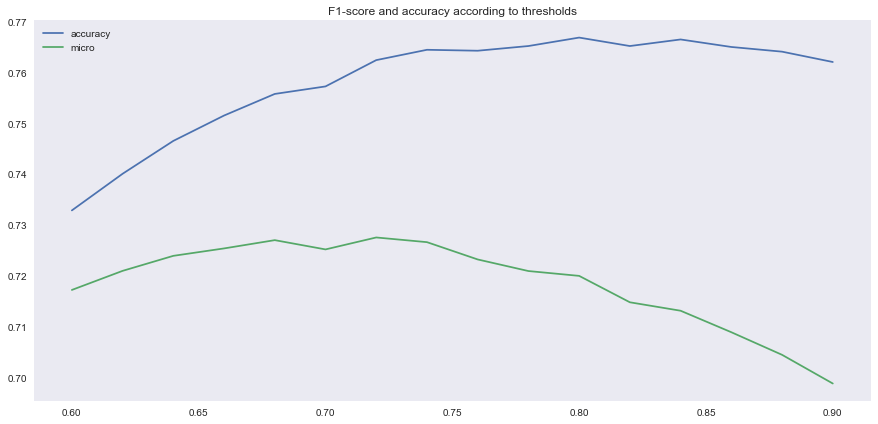

In [ ]:
fig = plt.figure(figsize=(15, 7))
plt.title('F1-score and accuracy according to thresholds')
plt.plot(thresholds, accuracy)
plt.plot(thresholds, f1_macro)
plt.grid(0)
plt.legend(('accuracy', 'micro'))
plt.show()

#### 1.4 Создание предсказаний для тестовой выборки, оценка качества 

*Был подобран следующий порог:*

In [ ]:
y_pred = prediction(data_test['text_1'].values, data_test['text_2'].values, 0.725, model)

In [ ]:
print('Test set accuracy score: %.3f' % accuracy_score(data_test['class_bin'], y_pred))
print('Test set f1_macro score: %.3f' % f1_score(data_test['class_bin'], y_pred, average='macro')) 

accuracy score: 0.7360265633646929
f1_macro score: 0.6956736345388971


# 2. Supervised I: сведение задачи к бинарной классификации

*Краткое описание:*
* векторизуем тексты несколькими способами
* выбираем модели, подбираем гиперпараметры
* оцениваем качество 

*Используемые модели эмбеддингов:*

 - word2vec 
 - word2vec with weights
 - doc2vec 
 - ELMo
 
*Модели классификации:*

 - LogisticRegression
 - SVM
 - RandomForest
 - GradientBoosting
 
 
 ! Для Word2Vec нужна отдельная функция лемматизации word -> lemma_tag
Можно сделать тремя способами:

- udpipe (но плохая лемматизация)
- mystem + смена тэгсета (но очень долго)
- pymorphy + смена тэгсета (но очень много чего теряем)

 ! Для Doc2vec обычная лемматизация из unsupervised части

## Embeddings

##### Необходимые функции:

In [ ]:
class score_report(object):
    '''
    Class for creating DataFrame with results
    '''
    
    def __init__(self):
        '''
        Constructor of class
        '''
        e = ['Word2Vec', 'Weighted_Word2Vec', 'Doc2Vec', 'Fasttext', 'Weighted_Fasttext']
        m = ['logreg_acc', 'logreg_f1', 'svm_acc', 'svm_f1', 
             'boost_acc', 'boost_f1', 'forest_acc', 'forest_f1']
        self.data = pd.DataFrame(index = e, columns = m)
        
    def add(self, score, clf, metric, embedding):
        '''
        Add score with corresponding name of model, metric and embedding model
        
        Parameters:
        -----------
        score: float
            Score of the model
        clf: str
            Name of model, for example: 'logreg'
        metric: str
            One of these metrics: 'acc' or 'f1' correspond to 'accuracy' and 'f1 macro score' respectfully
        embedding:
            Name of embedding model, for example: 'Word2Vec'
        
        '''
        
        model = clf + '_' + metric
        results = self.data
        results.loc[embedding][model] = score
    
    def show(self):
        '''
        Show DataFrame with results
        '''
        return self.data


In [ ]:
results = score_report()

### 2.1 Word2Vec: усредненный & усредненный с весами

#### Предобработка текста, разделение данных на обучающую и тестовую выборку [supervised] 
Для использования предобученной модель word2vec с RusVectores, то необходимо, чтобы слова в текстах имели вид **lemma + POS_tag** (корпус, на котором обучена модель, был обработан с помощью udpipe). 


##### Функция для предобработки с udpipe

In [ ]:
!pip install ufal.udpipe

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
!pip install conllu

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
from ufal.udpipe import Model, Pipeline
from conllu import parse

model = Model.load("russian-ud-2.0-170801.udpipe")
pipeline = Pipeline(model, 'generic_tokenizer', '', '', '')


def udpipe_processing(lst):
    pattern = re.compile("[А-Яа-я]+|[A-Za-z]+") 
    make_list = []
    for text in lst:
        words = ' '.join(pattern.findall(text))
        parsed = pipeline.process(words)
        sentence = parse(parsed)
        sents = []
        for i in range(len(sentence[0])):
            sents.append(sentence[0][i]['lemma'].lower() + '_' + sentence[0][i]['upostag']) 
            #конкатенируем лемму и тэг
        make_list.append(sents)
        
    return make_list

##### Функция для предобработки с mystem

*! Не забыть написать откуда взяли функцию* 

In [ ]:
!pip install pymystem3

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
from pymystem3 import Mystem

mapping = {'COM': 'ADJ',  #mystem : udpipe
           'APRO': 'DET',
           'PART': 'PART',
           'PR': 'ADP',
           'ADV': 'ADV',
           'INTJ': 'INTJ',
           'S': 'NOUN',
           'V': 'VERB',
           'CONJ': 'SCONJ',
           'UNKN': 'X',
           'ANUM': 'ADJ',
           'NUM': 'NUM',
           'NONLEX': 'X',
           'SPRO': 'PRON',
           'ADVPRO': 'ADV',
           'A': 'ADJ'}

def tag_mystem(doc):  
    m = Mystem()
    processed = m.analyze(doc)
    tagged = []
    for w in processed:
        try:
            lemma = w["analysis"][0]["lex"].lower().strip()
            pos = w["analysis"][0]["gr"].split(',')[0]
            pos = pos.split('=')[0].strip()
            if pos in mapping:
                tagged.append(lemma + '_' + mapping[pos]) # здесь мы конвертируем тэги
            else:
                tagged.append(lemma + '_X') # на случай, если попадется тэг, которого нет в маппинге
        except KeyError:
            continue # я здесь пропускаю знаки препинания, но вы можете поступить по-другому
    return tagged

def mystem_processing(lst):
    res = []
    for i in tqdm(range(len(lst))):
        res.append(tag_mystem(lst[i]))
    return res

#####  Функция для обработки с помощью pymorhy

In [ ]:
# словарь для замены POS-тэгов 
tags = {'ADJF':'ADJ', # pymorphy2 : udpipe 
'ADJS' : 'ADJ', 
'ADVB' : 'ADV', 
'COMP' : 'ADV', 
'GRND' : 'VERB', 
'INFN' : 'VERB', 
'NOUN' : 'NOUN', 
'PRED' : 'ADV', 
'PRTF' : 'ADJ', 
'PRTS' : 'VERB', 
'VERB' : 'VERB'}


def processing_with_tags(texts):
    prog = re.compile("[А-Яа-яёA-Za-z]+")
    morph = pymorphy2.MorphAnalyzer()
    make_list = []
    for text in tqdm(texts):
        line = prog.findall(str(text).lower())
        words = [morph.parse(token)[0].normal_form + '_' + tags[morph.parse(token)[0].tag.POS] for token in line
                if morph.parse(token)[0].tag.POS in tags.keys()]
        make_list.append(words)
    return make_list

##### Лемматизируем данные, делим на обучающую и тестовую выборку

In [ ]:
data['text_1'] = udpipe_processing(data['text_1'].values)

In [ ]:
data['text_2'] = udpipe_processing(data['text_2'].values)

In [ ]:
#pd.to_pickle(data, 'data_after_udpipe.pkl')

In [ ]:
data = pd.read_pickle('data_after_udpipe.pkl')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[['text_1', 'text_2']], data['class_bin'], test_size = 0.25,
                                                    random_state = 666)

In [ ]:
X_train['text_1'][0]

['полицейский_NOUN',
 'разрешат_VERB',
 'стрелять_VERB',
 'на_ADP',
 'поражение_NOUN',
 'по_ADP',
 'гражданин_NOUN',
 'с_ADP',
 'травматикой_NOUN']

#### Строим эмбеддинги: усредненный word2vec

In [ ]:
# загрузка предобученной модели
model = gensim.models.KeyedVectors.load_word2vec_format("ruscorpora_upos_skipgram_300_5_2018.vec.gz")

In [ ]:
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

In [ ]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(w2v.popitem()[1])

    def fit(self, X, y):
        return self

    def transform(self, X):
        return [np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X]

In [ ]:
mean_emb = MeanEmbeddingVectorizer(w2v)

In [ ]:
X_train_text_2 = mean_emb.transform(X_train.text_2.values)
X_test_text_2 = mean_emb.transform(X_test.text_2.values)

In [ ]:
X_train_text_1 = mean_emb.transform(X_train.text_1.values)
X_test_text_1 = mean_emb.transform(X_test.text_1.values)

In [ ]:
X_train = [np.concatenate((X_train_text_1[i], X_train_text_2[i])) for i in range(len(X_train_text_1))]
X_test = [np.concatenate((X_test_text_1[i], X_test_text_2[i])) for i in range(len(X_test_text_1))]

#### Word2Vec + LogReg, SVM, RandomForest, GradientBoosting

In [ ]:
pipe_logreg = LogisticRegression(random_state=666, n_jobs = -1)
pipe_svm = SVC(random_state=666)
pipe_forest = RandomForestClassifier(random_state=666)
pipe_boost = GradientBoostingClassifier(random_state=666)

grid_params_logreg = [{'penalty': ('l1', 'l2'),
                   'C': [1.0, 0.5, 0.1]}] 

grid_params_svm = [{'kernel': ('linear', 'poly', 'rbf'),
                   'C': [1.0, 0.5, 0.1],
                   'degree': [3, 5]}] 

grid_params_forest = [{'n_estimators' : [10, 20], 
                   'criterion': ('gini', 'entropy'),
                   'min_samples_leaf': [50, 100, 200],
                   'max_depth': [50, 100],
                   'min_samples_split': [50, 100]}]

grid_params_boost = [{'loss': ('deviance', 'exponential'), 
                    'min_samples_leaf': [50, 100], 
                    'subsample' : [0.5, 0.7, 1.0], 
                    'n_estimators' : [100, 200]}]


models = {'logreg' : [pipe_logreg, grid_params_logreg],
          'svm' : [pipe_svm, grid_params_svm], 
          'forest': [pipe_forest, grid_params_forest],
          'boost' : [pipe_boost, grid_params_boost]}

scoring = {'accuracy' : make_scorer(accuracy_score), 
          'f1_score_macro' : make_scorer(f1_score, average = 'macro')}


best_acc = 0.0
best_f1 = 0.0
best_clf_acc = ''
best_clf_f1 = ''


for clf in models.keys():
    print('\nEstimator: %s' % models[clf])
    grid_cv = GridSearchCV(estimator = models[clf][0], param_grid = models[clf][1][0], n_jobs = -1, 
                           scoring = scoring, refit = 'f1_score_macro')
    grid_cv.fit(X_train, y_train)
    print('Best params: %s' % grid_cv.best_params_)
    print('Best training accuracy: %.3f' % grid_cv.best_score_)
    y_pred = grid_cv.predict(X_test)
    print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))
    print('Test set f1_score (macro) for best params: %.3f ' % f1_score(y_test, y_pred, average='macro'))
    results.add(accuracy_score(y_test, y_pred), clf, 'acc', 'Word2Vec')
    results.add(f1_score(y_test, y_pred, average='macro'), clf, 'f1', 'Word2Vec')
    if accuracy_score(y_test, y_pred) > best_acc:
        best_acc = accuracy_score(y_test, y_pred)
        best_clf_acc = str(grid_cv.best_estimator_)
        
    if f1_score(y_test, y_pred, average='macro') > best_f1:
        best_f1 = f1_score(y_test, y_pred, average='macro')
        best_clf_f1 = str(grid_cv.best_estimator_)
        
print('\nClassifier with best test set accuracy: %s' % best_clf_acc)
print('\nClassifier with best test set f1 macro score: %s' % best_clf_f1)



Estimator: [LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=666, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), [{'penalty': ('l1', 'l2'), 'C': [1.0, 0.5, 0.1]}]]
Best params: {'C': 1.0, 'penalty': 'l2'}
Best training accuracy: 0.537
Test set accuracy score for best params: 0.679 
Test set f1_score (macro) for best params: 0.567 

Estimator: [SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=666, shrinking=True,
  tol=0.001, verbose=False), [{'kernel': ('linear', 'poly', 'rbf'), 'C': [1.0, 0.5, 0.1], 'degree': [3, 5]}]]
Best params: {'C': 1.0, 'degree': 3, 'kernel': 'linear'}
Best training accuracy: 0.503
Test set accuracy score for best params: 0.680 
Test set f1_score (macro) for best params: 0.51

#### Строим эмбеддинги: усредненный  word2vec с весами

In [ ]:
data = pd.read_pickle('data_after_udpipe.pkl')
data['class_bin'] = data['class'].apply(lambda x: 1 if x != -1 else -1).values

In [ ]:
data['text_1_con'] = [' '.join(text) for text in data['text_1']]
data['text_2_con'] = [' '.join(text) for text in data['text_2']]
corpus = pd.concat([data['text_1_con'], data['text_2_con']]).unique()

In [ ]:
corpus = pd.concat([data['text_1_con'], data['text_2_con']]).unique()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[['text_1', 'text_2']], data['class_bin'], test_size = 0.25,
                                                    random_state = 666)

In [ ]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(w2v.popitem()[1])

    def fit(self, X):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X])

In [ ]:
w2v = dict(zip(model.wv.index2word, model.wv.syn0)) #  модель эмбеддингов всё та же

In [ ]:
tf_emb = TfidfEmbeddingVectorizer(w2v)

In [ ]:
tf_emb.fit(corpus)

In [ ]:
X_train_text_1, X_test_text_1 = tf_emb.transform(X_train.text_1.values), tf_emb.transform(X_test.text_1.values)
X_train_text_2, X_test_text_2  = tf_emb.transform(X_train.text_2.values), tf_emb.transform(X_test.text_2.values)

In [ ]:
X_train = [np.concatenate((X_train_text_1[i], X_train_text_2[i])) for i in range(len(X_train_text_1))]
X_test = [np.concatenate((X_test_text_1[i], X_test_text_2[i])) for i in range(len(X_test_text_1))]

#### Weighted Word2Vec + LogReg, SVM, RandomForest, GradientBoosting

In [ ]:
pipe_logreg = LogisticRegression(random_state=666, n_jobs = -1)

pipe_svm = SVC(random_state=666)

pipe_forest = RandomForestClassifier(random_state=666)

pipe_boost = GradientBoostingClassifier(random_state=666)

grid_params_logreg = [{'penalty': ('l1', 'l2'),
                   'C': [1.0, 0.5, 0.1]}] 

grid_params_svm = [{'kernel': ('linear', 'poly', 'rbf'),
                   'C': [1.0, 0.5, 0.1],
                   'degree': [3, 5]}] 

grid_params_forest = [{'n_estimators' : [10, 20], 
                   'criterion': ('gini', 'entropy'),
                   'min_samples_leaf': [50, 100, 200],
                   'max_depth': [50, 100],
                   'min_samples_split': [50, 100]}]

grid_params_boost = [{'loss': ('deviance', 'exponential'), 
                    'min_samples_leaf': [50, 100], 
                    'subsample' : [0.5, 0.7, 1.0], 
                    'n_estimators' : [100, 200]}]


models = {'logreg' : [pipe_logreg, grid_params_logreg],
          'svm' : [pipe_svm, grid_params_svm], 
          'forest': [pipe_forest, grid_params_forest],
          'boost' : [pipe_boost, grid_params_boost]}

scoring = {'accuracy' : make_scorer(accuracy_score), 
          'f1_score_macro' : make_scorer(f1_score, average = 'macro')}


best_acc = 0.0
best_f1 = 0.0
best_clf_acc = ''
best_clf_f1 = ''


for clf in models.keys():
    print('\nEstimator: %s' % models[clf])
    grid_cv = GridSearchCV(estimator = models[clf][0], param_grid = models[clf][1][0], n_jobs = -1, 
                           scoring = scoring, refit = 'f1_score_macro')
    grid_cv.fit(X_train, y_train)
    print('Best params: %s' % grid_cv.best_params_)
    print('Best training accuracy: %.3f' % grid_cv.best_score_)
    y_pred = grid_cv.predict(X_test)
    print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))
    print('Test set f1_score (macro) for best params: %.3f ' % f1_score(y_test, y_pred, average='macro'))
    results.add(accuracy_score(y_test, y_pred), clf, 'acc', 'Weighted_Word2Vec')
    results.add(f1_score(y_test, y_pred, average='macro'), clf, 'f1', 'Weighted_Word2Vec')
    if accuracy_score(y_test, y_pred) > best_acc:
        best_acc = accuracy_score(y_test, y_pred)
        best_clf_acc = str(grid_cv.best_estimator_)
        
    if f1_score(y_test, y_pred, average='macro') > best_f1:
        best_f1 = f1_score(y_test, y_pred, average='macro')
        best_clf_f1 = str(grid_cv.best_estimator_)
        
print('\nClassifier with best test set accuracy: %s' % best_clf_acc)
print('\nClassifier with best test set f1 macro score: %s' % best_clf_f1)



Estimator: [LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=666, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), [{'penalty': ('l1', 'l2'), 'C': [1.0, 0.5, 0.1]}]]
Best params: {'C': 0.5, 'penalty': 'l2'}
Best training accuracy: 0.592
Test set accuracy score for best params: 0.644 
Test set f1_score (macro) for best params: 0.580 

Estimator: [SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=666, shrinking=True,
  tol=0.001, verbose=False), [{'kernel': ('linear', 'poly', 'rbf'), 'C': [1.0, 0.5, 0.1], 'degree': [3, 5]}]]
Best params: {'C': 0.5, 'degree': 3, 'kernel': 'linear'}
Best training accuracy: 0.591
Test set accuracy score for best params: 0.653 
Test set f1_score (macro) for best params: 0.58

### 2.2 Doc2vec

#### Лемматизируем данные, делим выборку на train и test, конкатенируем пары для создания корпуса для doc2vec

In [ ]:
data = pd.read_csv('data_hw2.csv')
data['class_bin'] = data['class'].apply(lambda x: 1 if x != -1 else -1).values

In [ ]:
data['text_1'] = simple_processing(data['text_1'].values)  # используем лемматизацию из unsupervised части

100%|██████████| 7227/7227 [00:21<00:00, 343.23it/s]


In [ ]:
data['text_2'] = simple_processing(data['text_2'].values)

100%|██████████| 7227/7227 [00:18<00:00, 381.10it/s]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[['text_1', 'text_2']], data['class_bin'], 
                                                    test_size=0.25, random_state=42)

In [ ]:
# строим корпус для обучения doc2vec
corpus = pd.DataFrame(pd.concat([X_train['text_1'], X_train['text_2']])).apply(lambda x: ' '.join(x[0]), axis = 1)
corpus = corpus.drop_duplicates(keep = 'first') #10840 -> 9263
corpus = corpus.apply(lambda x: x.split(' '))

#### Строим эмбеддинги: doc2vec

In [ ]:
tagged_data = [TaggedDocument(words=words, tags=[str(i)]) for i, words in enumerate(corpus.values)]
max_epochs = 20
vec_size = 100
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm=0,
                dbow_words=0)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    model.alpha -= 0.0002
    model.min_alpha = model.alpha



iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19


In [ ]:
class Doc2VecVectorizer(object):
    def __init__(self, d2v_model):
        self.d2v_model = d2v_model
        self.dim = d2v_model.vector_size
        
    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([self.d2v_model.infer_vector(text) for text in X])

In [ ]:
d2v = Doc2VecVectorizer(model)
X_train_text_2 = d2v.transform(X_train.text_2.values)
X_test_text_2 = d2v.transform(X_test.text_2.values)
X_train_text_1 = d2v.transform(X_train.text_1.values)
X_test_text_1 = d2v.transform(X_test.text_1.values)

In [ ]:
X_train = [np.concatenate((X_train_text_1[i], X_train_text_2[i])) for i in range(len(X_train_text_1))]
X_test = [np.concatenate((X_test_text_1[i], X_test_text_2[i])) for i in range(len(X_test_text_1))]

#### Doc2Vec + LogReg, SVM, RandomForest, GradientBoosting

In [ ]:
pipe_logreg = LogisticRegression(random_state=666, n_jobs = -1)

pipe_svm = SVC(random_state=666)

pipe_forest = RandomForestClassifier(random_state=666)

pipe_boost = GradientBoostingClassifier(random_state=666)

grid_params_logreg = [{'penalty': ('l1', 'l2'),
                   'C': [1.0, 0.5, 0.1]}] 

grid_params_svm = [{'kernel': ('linear', 'poly', 'rbf'),
                   'C': [1.0, 0.5, 0.1],
                   'degree': [3, 5]}] 

grid_params_forest = [{'n_estimators' : [10, 20], 
                   'criterion': ('gini', 'entropy'),
                   'min_samples_leaf': [50, 100, 200],
                   'max_depth': [50, 100],
                   'min_samples_split': [50, 100]}]

grid_params_boost = [{'loss': ('deviance', 'exponential'), 
                    'min_samples_leaf': [50, 100], 
                    'subsample' : [0.5, 0.7, 1.0], 
                    'n_estimators' : [100, 200]}]


models = {'logreg' : [pipe_logreg, grid_params_logreg],
          'svm' : [pipe_svm, grid_params_svm], 
          'forest': [pipe_forest, grid_params_forest],
          'boost' : [pipe_boost, grid_params_boost]}

scoring = {'accuracy' : make_scorer(accuracy_score), 
          'f1_score_macro' : make_scorer(f1_score, average = 'macro')}


best_acc = 0.0
best_f1 = 0.0
best_clf_acc = ''
best_clf_f1 = ''


for clf in models.keys():
    print('\nEstimator: %s' % models[clf])
    grid_cv = GridSearchCV(estimator = models[clf][0], param_grid = models[clf][1][0], n_jobs = -1, 
                           scoring = scoring, refit = 'f1_score_macro')
    grid_cv.fit(X_train, y_train)
    print('Best params: %s' % grid_cv.best_params_)
    print('Best training accuracy: %.3f' % grid_cv.best_score_)
    y_pred = grid_cv.predict(X_test)
    print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))
    print('Test set f1_score (macro) for best params: %.3f ' % f1_score(y_test, y_pred, average='macro'))
    results.add(accuracy_score(y_test, y_pred), clf, 'acc', 'Doc2Vec')
    results.add(f1_score(y_test, y_pred, average='macro'), clf, 'f1', 'Doc2Vec')
    if accuracy_score(y_test, y_pred) > best_acc:
        best_acc = accuracy_score(y_test, y_pred)
        best_clf_acc = str(grid_cv.best_estimator_)
        
    if f1_score(y_test, y_pred, average='macro') > best_f1:
        best_f1 = f1_score(y_test, y_pred, average='macro')
        best_clf_f1 = str(grid_cv.best_estimator_)
        
print('\nClassifier with best test set accuracy: %s' % best_clf_acc)
print('\nClassifier with best test set f1 macro score: %s' % best_clf_f1)


Estimator: [LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=666, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), [{'penalty': ('l1', 'l2'), 'C': [1.0, 0.5, 0.1]}]]
Best params: {'C': 1.0, 'penalty': 'l2'}
Best training accuracy: 0.599
Test set accuracy score for best params: 0.664 
Test set f1_score (macro) for best params: 0.610 

Estimator: [SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=666, shrinking=True,
  tol=0.001, verbose=False), [{'kernel': ('linear', 'poly', 'rbf'), 'C': [1.0, 0.5, 0.1], 'degree': [3, 5]}]]
Best params: {'C': 1.0, 'degree': 3, 'kernel': 'linear'}
Best training accuracy: 0.575
Test set accuracy score for best params: 0.678 
Test set f1_score (macro) for best params: 0.58

### FastText

#### Усредненный FastText 

In [ ]:
model = FastText.load_fasttext_format('cc.ru.300.bin')

In [ ]:
data = pd.read_csv('data_hw2.csv')
data['class_bin'] = data['class'].apply(lambda x: 1 if x != -1 else -1).values
data['text_1'] = simple_processing(data['text_1'])
data['text_2'] = simple_processing(data['text_2'])

100%|██████████| 7227/7227 [00:22<00:00, 321.42it/s]


In [ ]:
data['text_1_con'] = [' '.join(text) for text in data['text_1']]
data['text_2_con'] = [' '.join(text) for text in data['text_2']]

In [ ]:
corpus = pd.concat([data['text_1_con'], data['text_2_con']]).unique()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[['text_1', 'text_2']], data['class_bin'], test_size = 0.25,
                                                    random_state = 666)

In [ ]:
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

In [ ]:
mean_emb = MeanEmbeddingVectorizer(w2v)

In [ ]:
X_train_text_2 = mean_emb.transform(X_train.text_2.values)
X_test_text_2 = mean_emb.transform(X_test.text_2.values)

In [ ]:
X_train_text_1 = mean_emb.transform(X_train.text_1.values)
X_test_text_1 = mean_emb.transform(X_test.text_1.values)

In [ ]:
X_train = [np.concatenate((X_train_text_1[i], X_train_text_2[i])) for i in range(len(X_train_text_1))]
X_test = [np.concatenate((X_test_text_1[i], X_test_text_2[i])) for i in range(len(X_test_text_1))]

#### FastText + LogReg, SVM, RandomForest, GradientBoosting

In [ ]:
pipe_logreg = LogisticRegression(random_state=666, n_jobs = -1)

pipe_svm = SVC(random_state=666)

pipe_forest = RandomForestClassifier(random_state=666)

pipe_boost = GradientBoostingClassifier(random_state=666)

grid_params_logreg = [{'penalty': ('l1', 'l2'),
                   'C': [1.0, 0.5, 0.1]}] 

grid_params_svm = [{'kernel': ('linear', 'poly', 'rbf'),
                   'C': [1.0, 0.5, 0.1],
                   'degree': [3, 5]}] 

grid_params_forest = [{'n_estimators' : [10, 20], 
                   'criterion': ('gini', 'entropy'),
                   'min_samples_leaf': [50, 100, 200],
                   'max_depth': [50, 100],
                   'min_samples_split': [50, 100]}]

grid_params_boost = [{'loss': ('deviance', 'exponential'), 
                    'min_samples_leaf': [50, 100], 
                    'subsample' : [0.5, 0.7, 1.0], 
                    'n_estimators' : [100, 200]}]


models = {'logreg' : [pipe_logreg, grid_params_logreg],
          'svm' : [pipe_svm, grid_params_svm], 
          'forest': [pipe_forest, grid_params_forest],
          'boost' : [pipe_boost, grid_params_boost]}

scoring = {'accuracy' : make_scorer(accuracy_score), 
          'f1_score_macro' : make_scorer(f1_score, average = 'macro')}


best_acc = 0.0
best_f1 = 0.0
best_clf_acc = ''
best_clf_f1 = ''


for clf in models.keys():
    print('\nEstimator: %s' % models[clf])
    grid_cv = GridSearchCV(estimator = models[clf][0], param_grid = models[clf][1][0], n_jobs = -1, 
                           scoring = scoring, refit = 'f1_score_macro')
    grid_cv.fit(X_train, y_train)
    print('Best params: %s' % grid_cv.best_params_)
    print('Best training accuracy: %.3f' % grid_cv.best_score_)
    y_pred = grid_cv.predict(X_test)
    print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))
    print('Test set f1_score (macro) for best params: %.3f ' % f1_score(y_test, y_pred, average='macro'))
    results.add(accuracy_score(y_test, y_pred), clf, 'acc', 'Fasttext')
    results.add(f1_score(y_test, y_pred, average='macro'), clf, 'f1', 'Fasttext')
    
    if accuracy_score(y_test, y_pred) > best_acc:
        best_acc = accuracy_score(y_test, y_pred)
        best_clf_acc = str(grid_cv.best_estimator_)
        
    if f1_score(y_test, y_pred, average='macro') > best_f1:
        best_f1 = f1_score(y_test, y_pred, average='macro')
        best_clf_f1 = str(grid_cv.best_estimator_)
        
print('\nClassifier with best test set accuracy: %s' % best_clf_acc)
print('\nClassifier with best test set f1 macro score: %s' % best_clf_f1)



Estimator: [LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=666, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), [{'penalty': ('l1', 'l2'), 'C': [1.0, 0.5, 0.1]}]]
Best params: {'C': 1.0, 'penalty': 'l1'}
Best training accuracy: 0.569
Test set accuracy score for best params: 0.681 
Test set f1_score (macro) for best params: 0.573 

Estimator: [SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=666, shrinking=True,
  tol=0.001, verbose=False), [{'kernel': ('linear', 'poly', 'rbf'), 'C': [1.0, 0.5, 0.1], 'degree': [3, 5]}]]
Best params: {'C': 1.0, 'degree': 3, 'kernel': 'linear'}
Best training accuracy: 0.512
Test set accuracy score for best params: 0.677 
Test set f1_score (macro) for best params: 0.51

#### Weighted FastText

In [ ]:
data = pd.read_csv('data_hw2.csv')
data['class_bin'] = data['class'].apply(lambda x: 1 if x != -1 else -1).values
data['text_1'] = simple_processing(data['text_1'])
data['text_2'] = simple_processing(data['text_2'])

100%|██████████| 7227/7227 [00:22<00:00, 314.73it/s]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[['text_1', 'text_2']], data['class_bin'], test_size = 0.25,
                                                    random_state = 666)

In [ ]:
tf_emb = TfidfEmbeddingVectorizer(w2v)
tf_emb.fit(corpus)

In [ ]:
X_train_text_1, X_test_text_1 = tf_emb.transform(X_train.text_1.values), tf_emb.transform(X_test.text_1.values)
X_train_text_2, X_test_text_2  = tf_emb.transform(X_train.text_2.values), tf_emb.transform(X_test.text_2.values)

In [ ]:
X_train = [np.concatenate((X_train_text_1[i], X_train_text_2[i])) for i in range(len(X_train_text_1))]
X_test = [np.concatenate((X_test_text_1[i], X_test_text_2[i])) for i in range(len(X_test_text_1))]

#### Weightned FastText + LogReg, SVM, RandomForest, GradientBoosting

In [ ]:
pipe_logreg = LogisticRegression(random_state=666, n_jobs = -1)

pipe_svm = SVC(random_state=666)

pipe_forest = RandomForestClassifier(random_state=666)

pipe_boost = GradientBoostingClassifier(random_state=666)

grid_params_logreg = [{'penalty': ('l1', 'l2'),
                   'C': [1.0, 0.5, 0.1]}] 

grid_params_svm = [{'kernel': ('linear', 'poly', 'rbf'),
                   'C': [1.0, 0.5, 0.1],
                   'degree': [3, 5]}] 

grid_params_forest = [{'n_estimators' : [10, 20], 
                   'criterion': ('gini', 'entropy'),
                   'min_samples_leaf': [50, 100, 200],
                   'max_depth': [50, 100],
                   'min_samples_split': [50, 100]}]

grid_params_boost = [{'loss': ('deviance', 'exponential'), 
                    'min_samples_leaf': [50, 100], 
                    'subsample' : [0.5, 0.7, 1.0], 
                    'n_estimators' : [100, 200]}]


models = {'logreg' : [pipe_logreg, grid_params_logreg],
          'svm' : [pipe_svm, grid_params_svm], 
          'forest': [pipe_forest, grid_params_forest],
          'boost' : [pipe_boost, grid_params_boost]}

scoring = {'accuracy' : make_scorer(accuracy_score), 
          'f1_score_macro' : make_scorer(f1_score, average = 'macro')}


best_acc = 0.0
best_f1 = 0.0
best_clf_acc = ''
best_clf_f1 = ''


for clf in models.keys():
    print('\nEstimator: %s' % models[clf])
    grid_cv = GridSearchCV(estimator = models[clf][0], param_grid = models[clf][1][0], n_jobs = -1, 
                           scoring = scoring, refit = 'f1_score_macro')
    grid_cv.fit(X_train, y_train)
    print('Best params: %s' % grid_cv.best_paramеs_)
    print('Best training accuracy: %.3f' % grid_cv.best_score_)
    y_pred = grid_cv.predict(X_test)
    print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))
    print('Test set f1_score (macro) for best params: %.3f ' % f1_score(y_test, y_pred, average='macro'))
    results.add(accuracy_score(y_test, y_pred), clf, 'acc', 'Weighted_Fasttext')
    results.add(f1_score(y_test, y_pred, average='macro'), clf, 'f1', 'Weighted_Fasttext')
    if accuracy_score(y_test, y_pred) > best_acc:
        best_acc = accuracy_score(y_test, y_pred)
        best_clf_acc = str(grid_cv.best_estimator_)
        
    if f1_score(y_test, y_pred, average='macro') > best_f1:
        best_f1 = f1_score(y_test, y_pred, average='macro')
        best_clf_f1 = str(grid_cv.best_estimator_)
        
print('\nClassifier with best test set accuracy: %s' % best_clf_acc)
print('\nClassifier with best test set f1 macro score: %s' % best_clf_f1)



Estimator: [LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=666, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), [{'penalty': ('l1', 'l2'), 'C': [1.0, 0.5, 0.1]}]]
Best params: {'C': 1.0, 'penalty': 'l1'}
Best training accuracy: 0.631
Test set accuracy score for best params: 0.668 
Test set f1_score (macro) for best params: 0.608 

Estimator: [SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=666, shrinking=True,
  tol=0.001, verbose=False), [{'kernel': ('linear', 'poly', 'rbf'), 'C': [1.0, 0.5, 0.1], 'degree': [3, 5]}]]
Best params: {'C': 0.5, 'degree': 3, 'kernel': 'linear'}
Best training accuracy: 0.627
Test set accuracy score for best params: 0.670 
Test set f1_score (macro) for best params: 0.61

### Результаты

In [ ]:
results.show()

,logreg_acc,logreg_f1,svm_acc,svm_f1,boost_acc,boost_f1,forest_acc,forest_f1
Word2Vec,0.679026,0.56704,0.679579,0.517176,0.727726,0.667509,0.666851,0.489535
Weighted_Word2Vec,0.643608,0.579619,0.653016,0.580335,0.727726,0.667509,0.666851,0.489535
Doc2Vec,0.663531,0.609715,0.678473,0.580869,0.755396,0.720436,0.68124,0.548032
Fasttext,0.68124,0.572611,0.677366,0.514778,0.754842,0.702492,0.678473,0.522837
Weighted_Fasttext,0.667958,0.607941,0.669618,0.609702,0.749862,0.693834,0.677919,0.524241
